# Importing Libraries

In [73]:
import os
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, SimpleRNN
import keras_tuner

## Cleaning & Splitting the dataset --> to be replaced with standardized data file

In [41]:
news_final = pd.read_csv("news_final.csv")

target = news_final['fake']
features = news_final.drop('fake', axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.25) # 0.25 x 0.8 = 0.2, #20% valid

# Hypothesis 2: Testing Neural Network models

## Define Tokenizing, Padding, Plotting functions & Earlystopping

In [43]:
# # only words (can have - or ') will be generated as tokens
# create a list of elements each containing a list of words from each article in the corpus
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize

def corpus_to_vect(df_column):
    corpus_tokens = []
    stop_words = set(stopwords.words("english"))
    rtokenizer = RegexpTokenizer(r'[a-zA-Z\'\-]+') # matches any word that contains only letters, hyphens, and apostrophes
    docs = df_column.values
    for doc in docs:
        sents = sent_tokenize(doc)
        doc_tokens = []
        for sent in sents:
            sent_lowered = sent.lower()
            words = rtokenizer.tokenize(sent_lowered) # convert all words to lower case
            filtered = [word.strip() for word in words if word not in stop_words and len(word) > 1] # filter out stopwords
            doc_tokens.extend(filtered)
        corpus_tokens.append(doc_tokens)
    return corpus_tokens

def tokenize(train_data,val_data,test_data):
    train_data = corpus_to_vect(train_data)
    val_data = corpus_to_vect(val_data)
    test_data = corpus_to_vect(test_data)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data)

    train_data = tokenizer.texts_to_sequences(train_data)
    val_data = tokenizer.texts_to_sequences(val_data)
    test_data = tokenizer.texts_to_sequences(test_data)
    vocab = tokenizer.word_index
    return train_data,val_data,test_data,vocab

def pad(train_data,val_data,test_data,max_len):
    train_data = pad_sequences(train_data, padding='post', maxlen=max_len)
    val_data = pad_sequences(val_data, padding='post', maxlen=max_len)
    test_data = pad_sequences(test_data, padding='post', maxlen=max_len)
    return train_data,val_data,test_data

def plotHistory(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = history.epoch

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

## Training on titles only

In [44]:
X_train_title,X_val_title,X_test_title,vocab_title = tokenize(X_train['title'],X_val['title'],X_test['title'])
max_vocab_title = len(vocab_title) + 1 # Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
print("Vocab Size for Titles: {}".format(max_vocab_title))

# get length of longest title and pad all shorter titles to match length
max_len_title = max([len(x) for x in X_train_title] + [len(x) for x in X_test_title])
X_train_title,X_val_title,X_test_title = pad(X_train_title,X_val_title,X_test_title,max_len_title)
print("Max Title Length: {}".format(max_len_title))

Vocab Size for Titles: 19731
Max Title Length: 34


### Training a simple RNN model on titles only

In [45]:
rnn_title_model = Sequential([
    Embedding(max_vocab_title, 100, input_length=max_len_title),
    Bidirectional(SimpleRNN(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_title_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

rnn_title_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 34, 100)           1973100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              58624     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,031,981
Trainable params: 2,031,981
Non-trainable params: 0
_________________________________________________________________


In [46]:
%%time
rnn_title_history = rnn_title_model.fit(X_train_title, y_train, epochs=10, 
                    validation_data=(X_val_title, y_val), batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 90s 114ms/step - loss: 0.3061 - accuracy: 0.8709 - val_loss: 0.1806 - val_accuracy: 0.9356
Epoch 2/10
774/774 [==============================] - 86s 112ms/step - loss: 0.1151 - accuracy: 0.9609 - val_loss: 0.1450 - val_accuracy: 0.9436
Epoch 3/10
774/774 [==============================] - 92s 119ms/step - loss: 0.0566 - accuracy: 0.9829 - val_loss: 0.1837 - val_accuracy: 0.9408
Epoch 4/10
774/774 [==============================] - 86s 112ms/step - loss: 0.0320 - accuracy: 0.9903 - val_loss: 0.1956 - val_accuracy: 0.9369
CPU times: total: 8min 13s
Wall time: 5min 54s


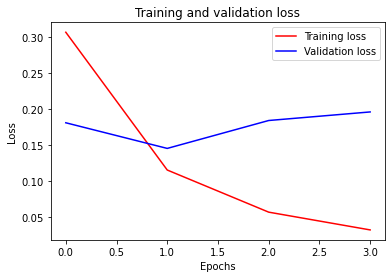

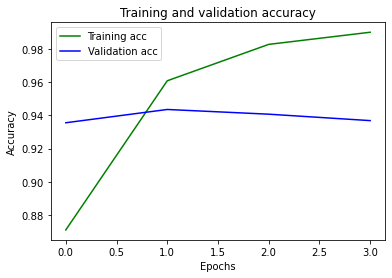

In [47]:
plotHistory(rnn_title_history)

In [48]:
rnn_title_model.evaluate(X_train_title, y_train)

725/725 [==============================] - 12s 16ms/step - loss: 0.0544 - accuracy: 0.9865


[0.05436372384428978, 0.9865482449531555]

In [49]:
rnn_title_model.evaluate(X_val_title, y_val)

242/242 [==============================] - 4s 16ms/step - loss: 0.1450 - accuracy: 0.9436


[0.14502878487110138, 0.9436109662055969]

In [50]:
rnn_title_model.evaluate(X_test_title, y_test)

242/242 [==============================] - 4s 16ms/step - loss: 0.1502 - accuracy: 0.9430


[0.15021859109401703, 0.9429643154144287]

### Training an LSTM model on titles only

In [51]:
lstm_title_model = Sequential([
    Embedding(max_vocab_title, 100, input_length=max_len_title),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_title_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

lstm_title_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 34, 100)           1973100   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,207,853
Trainable params: 2,207,853
Non-trainable params: 0
_________________________________________________________________


In [60]:
%%time
lstm_title_history = lstm_title_model.fit(X_train_title, y_train, epochs=10, 
                    validation_data=(X_val_title, y_val), batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 8s 10ms/step - loss: 0.0752 - accuracy: 0.9747 - val_loss: 0.1348 - val_accuracy: 0.9505
Epoch 2/10
774/774 [==============================] - 8s 10ms/step - loss: 0.0475 - accuracy: 0.9855 - val_loss: 0.1776 - val_accuracy: 0.9357
Epoch 3/10
774/774 [==============================] - 8s 10ms/step - loss: 0.0313 - accuracy: 0.9906 - val_loss: 0.1786 - val_accuracy: 0.9448
CPU times: total: 31.6 s
Wall time: 23.5 s


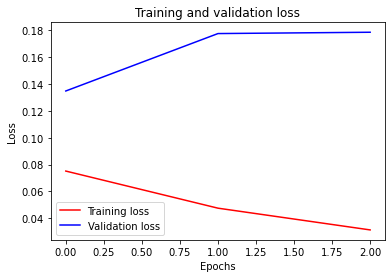

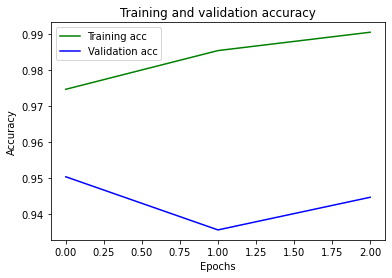

In [61]:
plotHistory(lstm_title_history)

In [62]:
lstm_title_model.evaluate(X_train_title, y_train)

725/725 [==============================] - 3s 4ms/step - loss: 0.0450 - accuracy: 0.9879


[0.04502788931131363, 0.9878848195075989]

In [63]:
lstm_title_model.evaluate(X_val_title, y_val)

242/242 [==============================] - 1s 5ms/step - loss: 0.1348 - accuracy: 0.9505


[0.134831964969635, 0.9504656195640564]

In [64]:
lstm_title_model.evaluate(X_test_title, y_test)

242/242 [==============================] - 1s 5ms/step - loss: 0.1357 - accuracy: 0.9472


[0.13569745421409607, 0.9472323060035706]

## Training on all text (title + text)

### Training the word2vec model on the dataset

<li>There are certain characteristics distinct to fake news that would be helpful for prediction (eg. number of capitalised words, punctuations etc. However, since word2vec trains better on words in their raw form, we will preprocess the text for this purpose while extracting the distinctive characteristics and train them in another classification model.</li>
<li>Since the use of language and choice of vocabulary differs between real and fake news, we will not lemmatise/stem the words in our corpus</li>


In [65]:
# training word2vec on the 'text' corpus to form the embedding layer
from gensim.models import Word2Vec

EMBEDDING_DIM = 100
w2v = Word2Vec(
    sentences = corpus_to_vect(X_train['all_text']),
    vector_size = EMBEDDING_DIM,
    window = 5,
    min_count = 1
)

In [66]:
num = len(w2v.wv)
print('There are a total of %d words in the vocabulary of our trained word2vec model.' % num)

There are a total of 108281 words in the vocabulary of our trained word2vec model.


In [67]:
w2v.wv["donald"]

array([-1.2755212e+00, -2.4483891e-01, -3.3259077e+00,  1.1881393e+00,
       -1.5453155e+00, -8.5365903e-01, -1.8547323e+00,  1.1752487e+00,
       -1.6967301e+00,  2.0702002e+00, -9.6109229e-01,  1.4290427e+00,
        5.4061264e-01,  3.0945629e-01, -5.4003048e-01,  1.7356414e+00,
        3.8711023e-01, -2.8266547e+00,  3.3998659e+00, -5.0392532e-01,
        8.4177375e-01,  2.2277739e+00, -7.3250580e-01, -1.3489498e+00,
        2.0691831e+00, -3.0194716e+00, -3.1585147e+00,  1.9094899e+00,
       -2.9544780e-01,  1.5127783e+00, -9.7127974e-02,  2.7210884e+00,
        9.9397534e-01,  2.4506335e+00,  2.4139216e+00,  1.3392528e+00,
       -1.3870788e+00,  7.9234135e-01,  1.9755086e+00, -1.7639482e-01,
        1.4515284e+00, -1.9390098e+00, -6.0140169e-01,  1.9122498e+00,
        2.2628219e-03, -4.8189834e-01, -6.2620573e-02, -1.0337194e+00,
        1.0380130e-01,  1.2568979e+00,  2.1662867e+00,  1.9928960e+00,
       -7.5888580e-01, -3.8710940e-01, -1.5432696e+00,  5.4171437e-01,
      

In [68]:
w2v.wv.most_similar("trump")

[('president-elect', 0.6297062039375305),
 ('instead', 0.526829719543457),
 ('course', 0.5192578434944153),
 ('actually', 0.5098420977592468),
 ('fact', 0.5029680132865906),
 ('conway', 0.49326539039611816),
 ('obama', 0.4837634563446045),
 ('yet', 0.4737081229686737),
 ('clearly', 0.46551617980003357),
 ('haiku', 0.4599129855632782)]

### Preparing the neural network model inputs

In [69]:
X_train_alltext,X_val_alltext,X_test_alltext, vocab_alltext = tokenize(X_train['all_text'],X_val['all_text'],X_test['all_text'])
max_vocab_alltext = len(vocab_alltext) + 1
print("Vocab Size for All Text: {}".format(max_vocab_alltext))

Vocab Size for All Text: 108282


In [70]:
# all token indexes generated from the first article
print(X_train_alltext[0])

[596, 4, 1478, 9658, 1326, 836, 378, 211, 7, 20, 11, 2, 596, 4, 913, 1478, 945, 4, 3491, 1326, 1282, 1137, 6929, 1195, 378, 211, 7, 142, 360, 5112, 1478, 1326, 9, 2265, 2438, 39808, 253, 1270, 459, 393, 3454, 5946, 874, 3455, 20, 11, 2, 78, 337, 218]


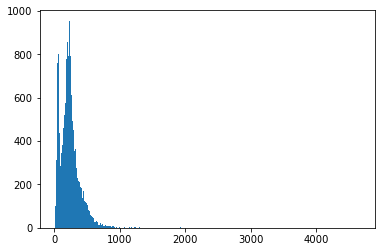

In [74]:
article_lens = np.array([len(index) for index in X_train_alltext])
plt.hist(article_lens, bins=500)
plt.show()

In [75]:
len_1000 = article_lens[article_lens < 1000]
print('%d out of %d articles have less than 1000 words' % (len(len_1000),len(article_lens)))

23102 out of 23194 articles have less than 1000 words


<li>Since the inputs to the neural network have to be of the same size, we have to pad each article in the dataset.</li>
<li>Since the majority of articles have less than 1000 words, we pad shorter news articles and truncate longer articles.</li>

In [76]:
max_len_alltext = 1000
X_train_alltext,X_val_alltext,X_test_alltext = pad(X_train_alltext,X_val_alltext,X_test_alltext,max_len_alltext)
print("Max All Text Length: {}".format(max_len_alltext))

Max All Text Length: 1000


In [77]:
# creating a weight matrix to retain weights learned by word2vec in the embedding layer later on
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # create weight matrix with number of rows = vocab_size and number of columns = number of embedding dimensions
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # for each word in the vocab, store its vector created by the word2vec model
    for word, row_index in vocab.items():
        weight_matrix[row_index] = model.wv[word]
    return weight_matrix

In [78]:
embedding_vectors = get_weight_matrix(w2v, vocab_alltext)

### Training a simple RNN model on all text

In [79]:
rnn_alltext_model = Sequential([
    Embedding(max_vocab_alltext, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len_alltext, trainable=False),
    Bidirectional(SimpleRNN(units=128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_alltext_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

rnn_alltext_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 100)         10828200  
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              58624     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 10,887,081
Trainable params: 58,881
Non-trainable params: 10,828,200
_________________________________________________________________


In [87]:
%%time
rnn_alltext_history = rnn_alltext_model.fit(X_train_alltext, y_train, epochs=10, 
                                validation_data=(X_val_alltext, y_val), batch_size=30, 
                                shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 1733s 2s/step - loss: 0.2064 - accuracy: 0.9314 - val_loss: 0.1804 - val_accuracy: 0.9399
Epoch 2/10
774/774 [==============================] - 1685s 2s/step - loss: 0.1834 - accuracy: 0.9407 - val_loss: 0.1634 - val_accuracy: 0.9470
Epoch 3/10
774/774 [==============================] - 1671s 2s/step - loss: 0.1656 - accuracy: 0.9487 - val_loss: 0.1577 - val_accuracy: 0.9507
Epoch 4/10
774/774 [==============================] - 1669s 2s/step - loss: 0.1661 - accuracy: 0.9474 - val_loss: 0.1546 - val_accuracy: 0.9484
Epoch 5/10
774/774 [==============================] - 1672s 2s/step - loss: 0.1630 - accuracy: 0.9495 - val_loss: 0.1496 - val_accuracy: 0.9512
Epoch 6/10
774/774 [==============================] - 1680s 2s/step - loss: 0.1491 - accuracy: 0.9538 - val_loss: 0.1490 - val_accuracy: 0.9484
Epoch 7/10
774/774 [==============================] - 1680s 2s/step - loss: 0.1458 - accuracy: 0.9550 - val_loss: 0.1435 - val_accuracy:

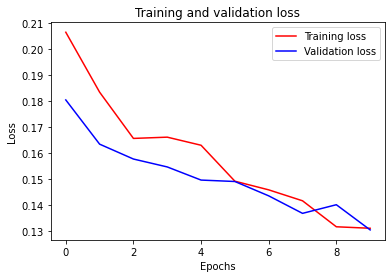

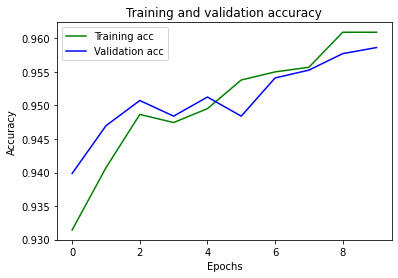

In [88]:
plotHistory(rnn_alltext_history)

In [89]:
rnn_alltext_model.evaluate(X_train_alltext, y_train)

725/725 [==============================] - 266s 367ms/step - loss: 0.1161 - accuracy: 0.9646


[0.11612874269485474, 0.96455979347229]

In [90]:
rnn_alltext_model.evaluate(X_val_alltext, y_val)

242/242 [==============================] - 88s 365ms/step - loss: 0.1304 - accuracy: 0.9586


[0.13042132556438446, 0.9586135745048523]

In [91]:
rnn_alltext_model.evaluate(X_test_alltext, y_test)

242/242 [==============================] - 89s 367ms/step - loss: 0.1369 - accuracy: 0.9550


[0.13688859343528748, 0.9549922347068787]

### Training an LSTM model on all text

In [92]:
lstm_alltext_model = Sequential([
    Embedding(max_vocab_alltext, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len_alltext, trainable=False),
    Bidirectional(LSTM(units=128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_alltext_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

lstm_alltext_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1000, 100)         10828200  
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 11,062,953
Trainable params: 234,753
Non-trainable params: 10,828,200
_________________________________________________________________


In [93]:
%%time
lstm_alltext_history = lstm_alltext_model.fit(X_train_alltext, y_train, epochs=10, 
                                validation_data=(X_val_alltext, y_val), batch_size=30, 
                                shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 63s 77ms/step - loss: 0.1838 - accuracy: 0.9333 - val_loss: 0.0928 - val_accuracy: 0.9692
Epoch 2/10
774/774 [==============================] - 59s 76ms/step - loss: 0.0843 - accuracy: 0.9715 - val_loss: 0.0696 - val_accuracy: 0.9771
Epoch 3/10
774/774 [==============================] - 59s 76ms/step - loss: 0.0673 - accuracy: 0.9776 - val_loss: 0.0588 - val_accuracy: 0.9809
Epoch 4/10
774/774 [==============================] - 59s 76ms/step - loss: 0.0568 - accuracy: 0.9821 - val_loss: 0.0545 - val_accuracy: 0.9824
Epoch 5/10
774/774 [==============================] - 59s 76ms/step - loss: 0.0469 - accuracy: 0.9844 - val_loss: 0.0582 - val_accuracy: 0.9811
Epoch 6/10
774/774 [==============================] - 59s 76ms/step - loss: 0.0445 - accuracy: 0.9851 - val_loss: 0.0473 - val_accuracy: 0.9837
Epoch 7/10
774/774 [==============================] - 59s 76ms/step - loss: 0.0510 - accuracy: 0.9824 - val_loss: 0.0486 - val_accuracy:

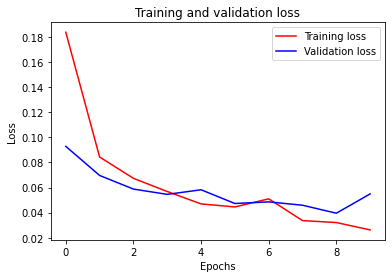

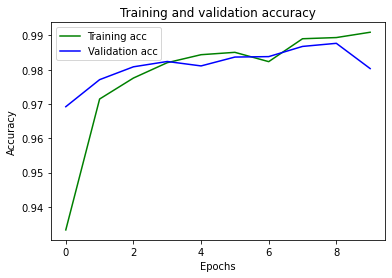

In [94]:
plotHistory(lstm_alltext_history)

In [95]:
lstm_alltext_model.evaluate(X_train_alltext, y_train)

725/725 [==============================] - 27s 37ms/step - loss: 0.0309 - accuracy: 0.9894


[0.03091881424188614, 0.9893506765365601]

In [96]:
lstm_alltext_model.evaluate(X_val_alltext, y_val)

242/242 [==============================] - 9s 37ms/step - loss: 0.0549 - accuracy: 0.9803


[0.0549151711165905, 0.9803414344787598]

In [97]:
lstm_alltext_model.evaluate(X_test_alltext, y_test)

242/242 [==============================] - 9s 36ms/step - loss: 0.0495 - accuracy: 0.9849


[0.04950638487935066, 0.9848681092262268]

### Hyperparameter tuning for LSTM model for all text

In [98]:
def hyperparameterTuning(hp): #https://keras.io/api/keras_tuner/hyperparameters/
    model = Sequential([
        Embedding(max_vocab_alltext, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len_alltext, trainable=False),
        Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=192, step=64))), #https://keras.io/api/layers/recurrent_layers/simple_rnn/
        Dropout(rate=hp.Float('rate', min_value=0.3, max_value=0.7, step=0.2)), #https://keras.io/api/layers/regularization_layers/dropout/
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    return model

In [99]:
#https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
tuner = keras_tuner.BayesianOptimization(hyperparameterTuning,
                              objective='val_loss',
                             directory='lstm_tuner2')

In [100]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
tuner.search(X_train_alltext, y_train, epochs=10, 
            validation_data=(X_val_alltext, y_val), batch_size=30, 
            shuffle=True, callbacks=[early_stop])

Trial 10 Complete [00h 09m 58s]
val_loss: 0.04726569354534149

Best val_loss So Far: 0.03519487380981445
Total elapsed time: 01h 47m 50s
INFO:tensorflow:Oracle triggered exit


In [101]:
tuner.results_summary()

Results summary
Results in lstm_tuner2\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
rate: 0.3
Score: 0.03519487380981445
Trial summary
Hyperparameters:
units: 192
rate: 0.3
Score: 0.03970800340175629
Trial summary
Hyperparameters:
units: 192
rate: 0.7
Score: 0.04148132726550102
Trial summary
Hyperparameters:
units: 128
rate: 0.7
Score: 0.042161814868450165
Trial summary
Hyperparameters:
units: 128
rate: 0.5
Score: 0.04451650008559227
Trial summary
Hyperparameters:
units: 192
rate: 0.3
Score: 0.04726569354534149
Trial summary
Hyperparameters:
units: 192
rate: 0.5
Score: 0.04821743443608284
Trial summary
Hyperparameters:
units: 64
rate: 0.5
Score: 0.0489145964384079
Trial summary
Hyperparameters:
units: 64
rate: 0.7
Score: 0.05317825824022293
Trial summary
Hyperparameters:
units: 128
rate: 0.3
Score: 0.06557958573102951


In [102]:
best_lstm_model = tuner.get_best_models(num_models=1)[0]

In [103]:
best_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         10828200  
                                                                 
 bidirectional (Bidirectiona  (None, 384)              450048    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 1)                 385       
                                                                 
Total params: 11,278,633
Trainable params: 450,433
Non-trainable params: 10,828,200
_________________________________________________________________


In [104]:
best_lstm_model.evaluate(X_train_alltext, y_train)

725/725 [==============================] - 29s 39ms/step - loss: 0.0192 - accuracy: 0.9933


[0.01915656216442585, 0.9933172464370728]

In [105]:
best_lstm_model.evaluate(X_val_alltext, y_val)

242/242 [==============================] - 9s 39ms/step - loss: 0.0352 - accuracy: 0.9886


[0.03519487753510475, 0.9886187314987183]

In [106]:
best_lstm_model.evaluate(X_test_alltext, y_test)

242/242 [==============================] - 9s 39ms/step - loss: 0.0369 - accuracy: 0.9877


[0.03685575723648071, 0.9877133965492249]